In [ ]:
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

In [ ]:
# Load the breast cancer dataset
data = load_breast_cancer()
X, y = data.data, data.target

In [ ]:
# Preprocess the data using min-max scaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Define the objective function for feature selection
def fitness_function(selected_features):
    # Convert boolean array to indices of selected features
    selected_indices = np.where(selected_features)[0]

    # Use a classifier for evaluation (Random Forest in this example)
    clf = RandomForestClassifier(n_estimators=100, random_state=42)
    clf.fit(X_train[:, selected_indices], y_train)
    
    # Return the accuracy as the objective to maximize
    accuracy = clf.score(X_test[:, selected_indices], y_test)
    fitness_value = np.abs(1 - accuracy)  # Minimize the error (1 - accuracy)
    return fitness_value


In [ ]:
# Particle Swarm Optimization (PSO) Algorithm
def pso(objective_function, dimensions, num_particles, max_iter, c1, c2, w):
    # Initialize particles randomly
    particles_position = np.random.randint(2, size=(num_particles, dimensions))
    particles_velocity = np.random.uniform(low=0, high=1, size=(num_particles, dimensions))


    # Initialize personal best positions and values
    personal_best_positions = particles_position.copy()
    personal_best_values = np.zeros(num_particles)

    # Initialize global best position and value
    global_best_position = None
    global_best_value = float('inf')

    # Store fitness values over iterations
    fitness_values = []

    # PSO optimization loop
    for iteration in range(max_iter):
        # Evaluate fitness for each particle
        for i in range(num_particles):
            fitness = objective_function(particles_position[i])
            
            # Update personal best if improved
            if fitness < personal_best_values[i]:
                personal_best_values[i] = fitness
                personal_best_positions[i] = particles_position[i].copy()
            
            # Update global best if improved
            if fitness < global_best_value:
                global_best_value = fitness
                global_best_position = personal_best_positions[i].copy()
        
        # Update velocities and positions
        for i in range(num_particles):
            r1, r2 = np.random.rand(), np.random.rand()
            cognitive_component = c1 * r1 * (personal_best_positions[i] - particles_position[i])
            social_component = c2 * r2 * (global_best_position - particles_position[i])
            particles_velocity[i] = w * particles_velocity[i] + cognitive_component + social_component
            particles_position[i] = np.clip(np.round(particles_position[i] + particles_velocity[i]), 0, 1)

        # Store the best fitness value in this iteration
        fitness_values.append(global_best_value)
        # Display current iteration and best value
        #print(f"Iteration {iteration + 1}/{max_iter}: Best Value = {global_best_value}")

    # Extract the selected features based on the global best position
    selected_features = np.round(global_best_position).astype(bool)

    return selected_features, fitness_values

In [ ]:
# PSO parameters
num_particles = 10
dimensions = X.shape[1]  # Number of features
max_iter = 100
c1, c2, weight = 0.5, 0.3, 0.9
num_runs = 100 # Number of parallel runs

In [ ]:
# Initialize importance list and best fitness values list
importance = np.zeros(dimensions)
best_fitness_values = []

In [ ]:
# Function to run PSO for a single run
def run_pso_single(_):
    return pso(fitness_function, dimensions, num_particles, max_iter, c1, c2, weight)

In [ ]:
# Run the PSO algorithm in parallel
with ThreadPoolExecutor(max_workers=num_runs) as executor:
    results = list(executor.map(run_pso_single, range(num_runs)))

In [ ]:
# Process the results
for run, (selected_features, fitness_values) in enumerate(results):
    # Update importance based on selected features
    importance += selected_features.astype(int)

    # Store the best fitness value of each run
    best_fitness_values.append(fitness_values)

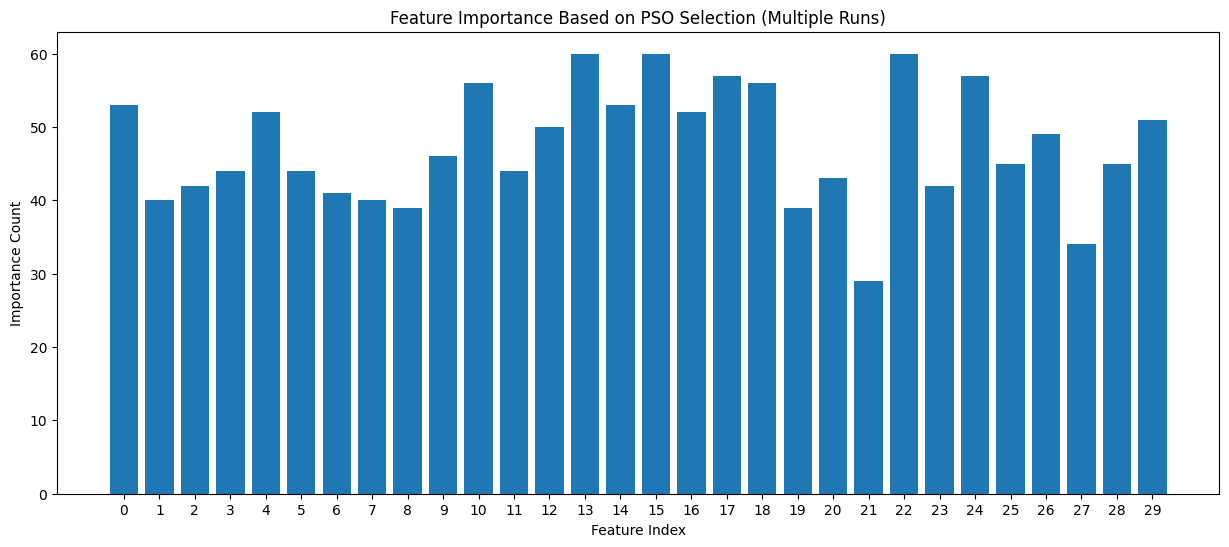

In [ ]:
# Visualize the importance of each feature along with its index
plt.figure(figsize=(15, 6))
plt.bar(range(dimensions), importance)
plt.title("Feature Importance Based on PSO Selection (Multiple Runs)")
plt.xlabel("Feature Index")
plt.ylabel("Importance Count")
# Display feature indices on the x-axis
plt.xticks(range(dimensions), [str(i) for i in range(dimensions)])

plt.show()

In [ ]:
# Calculate ratios of importance
total_runs = len(best_fitness_values)
importance_ratios = importance / total_runs

# Sort features based on importance
sorted_indices = np.argsort(importance_ratios)[::-1]
print(sorted_indices)

[13 15 22 24 17 18 10 14  0  4 16 29 12 26  9 25 28  3 11  5 20 23  2  6
  7  1  8 19 27 21]


C:\Users\amerz\AppData\Local\Temp\ipykernel_19256\3677454263.py:12: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(0,.04, max(np.max(run) for run in best_fitness_values))


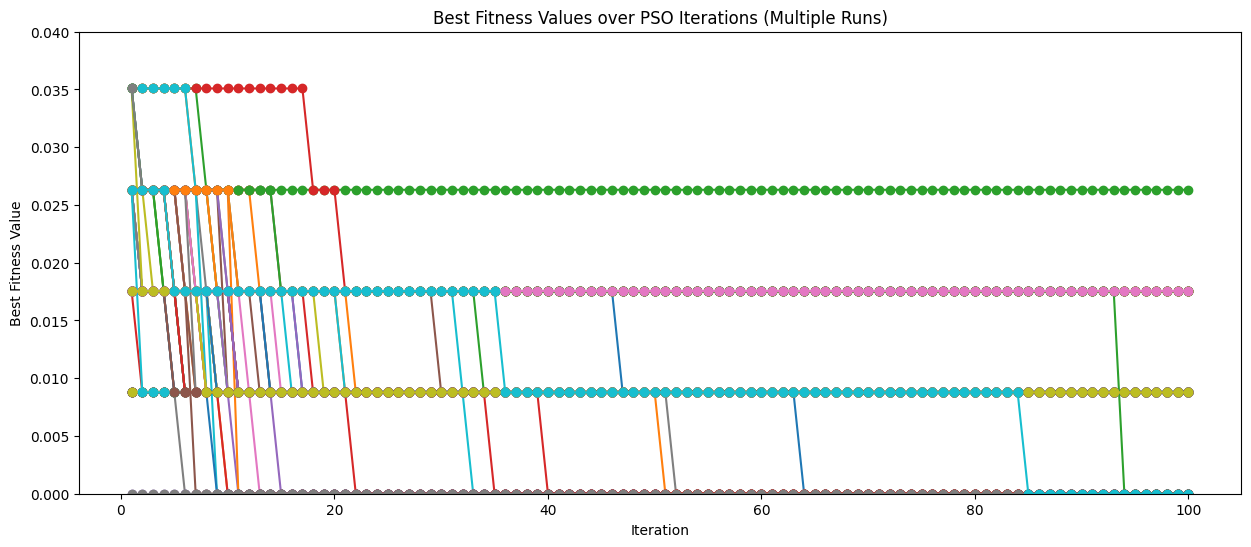

In [ ]:
# Visualize the best fitness values over iterations for each run
plt.figure(figsize=(15, 6))
for run in best_fitness_values:
    plt.plot(range(1, max_iter + 1), run, marker='o')

plt.title("Best Fitness Values over PSO Iterations (Multiple Runs)")
plt.xlabel("Iteration")
plt.ylabel("Best Fitness Value")
#plt.legend([f"Run {i+1}" for i in range(num_runs)])

# Set y-axis to start from the origin
plt.ylim(0,.04, max(np.max(run) for run in best_fitness_values))
plt.show()